In [147]:
from hapi import *
import numpy as np
import matplotlib.pyplot as plt

# Initialize HITRAN database
db_begin('data')

# Gases and HITRAN molecule numbers
gases = {
    #'H2O': 1,
    #'CO2': 2,
    'O3': 3,
    'N2O': 4,
    'CO': 5,
    'CH4': 6,
    #'O2': 7,
    #'NO': 8,
    'SO2': 9,
    'NO2': 10
    
}

# Wavenumber range
#nu_min = 900
#nu_max = 1700

nu_min = 2000
nu_max = 3200

# Fetch HITRAN data for each gas, using the most abundant isotope (isotope 1)
for gas, ID in gases.items():
    fetch(gas, ID, 1, nu_min, nu_max)  # fixed: use isotope 1



Using data

C2H4
                     Lines parsed: 6618
C2H6
                     Lines parsed: 9851
CH4
                     Lines parsed: 46166
CO
                     Lines parsed: 224
N2O
                     Lines parsed: 13071
NO2
                     Lines parsed: 43910
O3
                     Lines parsed: 108731
SO2
                     Lines parsed: 80525

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: O3
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
 

  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 bytes written to data/O3.data
  65536 byte

  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to data/SO2.data
  65536 bytes written to 

                     Lines parsed: 41236
PROCESSED


In [148]:
# Wavenumber grid
step = 1.0
nu_grid = np.arange(nu_min, nu_max, step)

path_length = 0.013 # centimeters
temp = 296 # kelvin
pressure = 1 # atm

In [186]:
import pandas as pd
import time

def spectral_sim(gas_concentrations):
    """
    gas_concentrations: dictionary of gas names and their mole fractions
    Example: {'H2O': 0.02, 'CO2': 0.0004}
             or {'CO2': 1.0} for pure CO2
    Returns:
        wavelength_nm: array of wavelengths in nanometers (nm)
        trans: array of transmittance values
    """  
    
    if not hasattr(spectral_sim, "initialized"):
        db_begin('data')

        gases = {
            #'H2O': 1,
            #'CO2': 2,
            'O3': 3,
            'N2O': 4,
            'CO': 5,
            'CH4': 6,
            #'O2': 7,
            #'NO': 8,
            'SO2': 9,
            'NO2': 10,
        }

        spectral_sim.initialized = True
    
    gases_to_simulate = [gas for gas, conc in gas_concentrations.items() if conc > 0]
    
    total_conc = sum(conc for conc in gas_concentrations.values() if conc > 0)
    
    environment_dict = {
        'T': temp,
        'p': pressure,
        'l': path_length,
        'VMR': {gas: conc for gas, conc in gas_concentrations.items() if conc > 0}
    }
    
    nu, coeff = absorptionCoefficient_Voigt(
        SourceTables=gases_to_simulate,
        Diluent={'air': max(0.0, 1.0 - total_conc)},
        Environment=environment_dict,
        OmegaGrid=nu_grid,
        HITRAN_units=False
    )

    # Compute transmittance
    nu, trans = transmittanceSpectrum(nu, coeff, Environment=environment_dict)

    # Convert wavenumber (cm⁻¹) to wavelength (nm)
    wavelength_nm = 1e7 / nu
    wavelength_nm = wavelength_nm[::-1]
    trans = 1 - trans[::-1]
    #time.sleep(1)
    
    return trans


In [192]:
air_samples_df = pd.read_csv("CO_label_single.csv")
print(air_samples_df.head(10))
print(air_samples_df.info())

         CO
0  0.259207
1  0.054389
2  0.108937
3  0.031179
4  0.016764
5  0.277985
6  0.245864
7  0.123386
8  0.269070
9  0.099146
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO      4000 non-null   float64
dtypes: float64(1)
memory usage: 31.4 KB
None


In [193]:
import time
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

spectra_arr = []
first_start_time = time.time()

rows_list = air_samples_df.to_dict(orient='records')

# Parallel processing using joblib
with tqdm_joblib(tqdm(desc="Processing rows", total=len(rows_list))):
    spectra_arr = Parallel(n_jobs=-1)(delayed(spectral_sim)(row) for row in rows_list)

# Measure total elapsed time
end_time = time.time()
print(f"Total Elapsed time: {end_time - first_start_time:.4f} seconds")









Processing rows:   0%|                | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Total Elapsed time: 4153.7818 seconds


In [194]:
dataset_df = pd.DataFrame(spectra_arr, columns=(1e7/nu_grid)[::-1])
dataset_df.to_csv("CO_spectra_single.csv")

4000


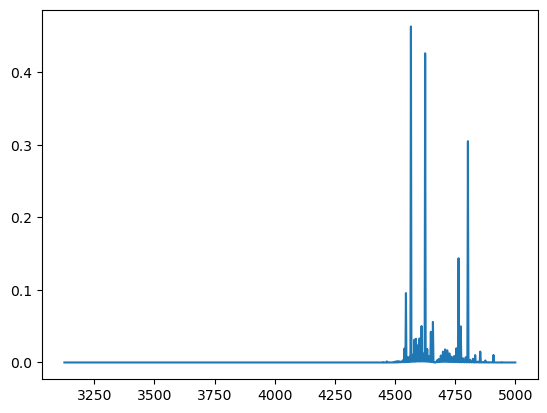

In [195]:
print(len(spectra_arr))
plt.plot((1e7/nu_grid)[::-1], spectra_arr[0])
#plt.xlim(2500, 3300)
#plt.ylim(-85, -15)
plt.show()

{'air': 0.7}
2.294392 seconds elapsed for abscoef; nlines = 10116
{'air': 0.8}
2.283444 seconds elapsed for abscoef; nlines = 10116
{'air': 0.9}
2.300337 seconds elapsed for abscoef; nlines = 10116



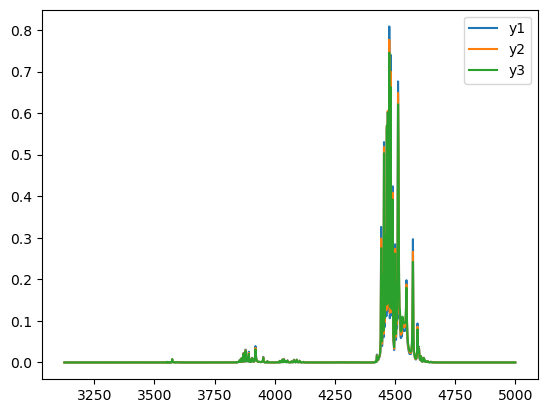

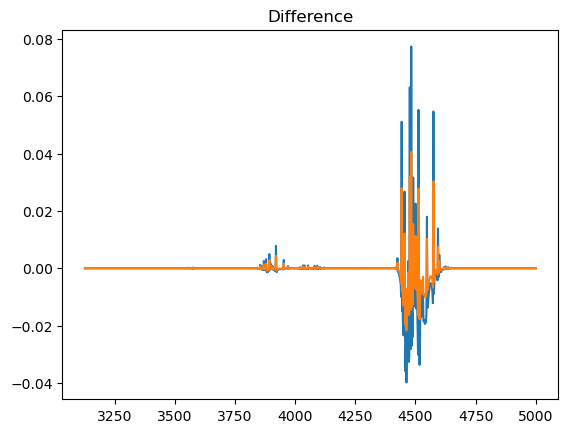

In [155]:
x = (1e7 / nu_grid)[::-1]
y1 = spectral_sim({'N2O': 0.3, 'SO2':0, 'O3':0})
y2 = spectral_sim({'N2O': 0.2, 'SO2':0, 'O3':0})
y3 = spectral_sim({'N2O': 0.1, 'SO2':0, 'O3':0})

print()

plt.plot(x, y1, label='y1')
plt.plot(x, y2, label='y2')
plt.plot(x, y3, label='y3')
plt.legend()
plt.show()


delta_A = y1 - y3
delta_B = y1 - y2
plt.plot(x, delta_A)
plt.plot(x, delta_B)
plt.title("Difference")
plt.show()


{'air': 0.7}
0.067406 seconds elapsed for abscoef; nlines = 224
{'air': 0.7}
2.199930 seconds elapsed for abscoef; nlines = 10116
{'air': 0.7}
8.489937 seconds elapsed for abscoef; nlines = 43043



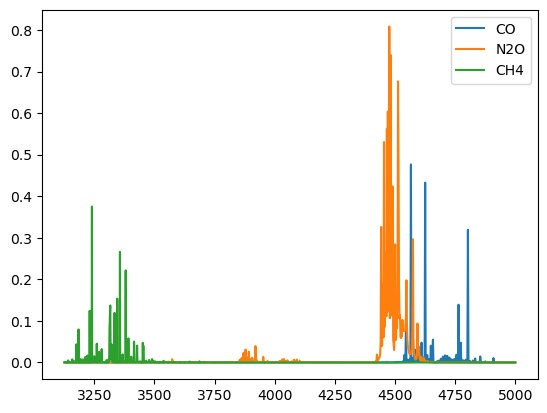

In [151]:
x = (1e7 / nu_grid)[::-1]
y1 = spectral_sim({'CO': 0.3, 'N2O':0, 'CH4':0})
y2 = spectral_sim({'CO': 0, 'N2O':0.3, 'CH4':0})
y3 = spectral_sim({'CO': 0, 'N2O':0, 'CH4':0.3})

print()

plt.plot(x, y1, label='CO')
plt.plot(x, y2, label='N2O')
plt.plot(x, y3, label='CH4')
plt.legend()
plt.show()